# Proyecto final: detección de convulsiones epilépticas a partir de señales EEG (Electroencefalografía)



---
Por: Ángela Daniela Córdoba Álvarez

---
Docente: Andrés Escallón.



## CHB-MIT Scalp EEG

En este proyecto haremos uso de uno de los datasets más grandes y utilizados en la investigación de EEG: *'TUH EEG Seizure Corpus'*, específicamente, el Database de *CHB-MIT Scalp EEG*.
Este es un conjunto de datos de registros de EEG de individuos pediátricos con convulsiones intratables. Estos individuos fueron monitoreados durante varios días después de la suspensión de la medicación anticonvulsiva, esto permitió poder caracterizar sus convulsiones y evaluar su candidatura para una intervención quirúrgica en caso de ser necesario.

El conjunto de datos contiene 23 pacientes divididos en 24 casos (un paciente tiene 2 registros, con 1,5 años de diferencia). El conjunto de datos consta de 969 horas de registros de EEG del cuero cabelludo con 173 convulsiones. Existen varios tipos de convulsiones en el conjunto de datos (clónicas, atónicas, tónicas). La diversidad de pacientes (hombres, mujeres, de 10 a 22 años) y los diferentes tipos de convulsiones contenidos en los conjuntos de datos son ideales para evaluar el rendimiento de los métodos de detección automática de convulsiones en entornos realistas.

### Importamos las librerías a usar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

!pip install matplotlib pandas numpy scipy seaborn mne
!pip install beautifulsoup4 requests wget
!pip install h5py tables kaggle
!pip install wfdb pyEDFlib

### Descargamos los datos

El cargue de los datasets correspondientes están basados en el trabajo de David Luke Elliott (https://github.com/Eldave93/Seizure-Detection-Tutorials/blob/master/01.%20Overview%20of%20Datasets.ipynb) y de NathalyDM (https://github.com/NathalyDM/genetifics/blob/main/EEGAnalisis/Cerebellar_Seizures_Tutorial.ipynb).

In [2]:
# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

plot_kwargs = {
    'scalings': dict(eeg=20e-5),   # zooms the plot out
    'highpass': 0.5,              # filters out low frequencies
    'lowpass': 70.,                # filters out high frequencies
    'show_scrollbars': False,
    'show': True
}

print(color.BOLD+color.UNDERLINE+'Title'+color.END)

Title


En este notebook se hace uso de una recopilación de diferentes datasets con relación en el mismo tema:

#### CHB-MIT Scalp EEG Database

In [3]:
import wfdb
import os
from urllib.request import urlretrieve

# Obtener la lista de bases de datos disponibles en PhysioNet
available_dbs = wfdb.get_dbs()

# Obtener la lista de registros para la base de datos 'chbmit'
records_list = wfdb.io.get_record_list('chbmit', records='all')

# Obtener códigos de participantes únicos ordenados
participant_codes = sorted(list(set([record.split('/')[0] for record in records_list])))

def download_and_read_summary(participant_code):
    # Construir la URL para el archivo de resumen del participante
    url = f"https://physionet.org/physiobank/database/chbmit/{participant_code}/{participant_code}-summary.txt"

    # Descargar el archivo de resumen
    filename = f"./chbmit_{participant_code}_summary.txt"
    urlretrieve(url, filename)

    # Leer el contenido del archivo
    with open(filename, encoding='UTF-8') as file:
        # Leer el documento y almacenarlo en una lista de cadenas
        content = file.readlines()
        # Eliminar el archivo después de leerlo
        os.remove(filename)

    return content

# Obtener y mostrar el contenido del resumen para el tercer participante en la lista
participant_code_to_download = participant_codes[2]
participant_summary = download_and_read_summary(participant_code_to_download)

# Imprimir el contenido con saltos de línea
for line in participant_summary:
    print(line.strip())

Data Sampling Rate: 256 Hz
*************************

Channels in EDF Files:
**********************
Channel 1: FP1-F7
Channel 2: F7-T7
Channel 3: T7-P7
Channel 4: P7-O1
Channel 5: FP1-F3
Channel 6: F3-C3
Channel 7: C3-P3
Channel 8: P3-O1
Channel 9: FP2-F4
Channel 10: F4-C4
Channel 11: C4-P4
Channel 12: P4-O2
Channel 13: FP2-F8
Channel 14: F8-T8
Channel 15: T8-P8
Channel 16: P8-O2
Channel 17: FZ-CZ
Channel 18: CZ-PZ
Channel 19: P7-T7
Channel 20: T7-FT9
Channel 21: FT9-FT10
Channel 22: FT10-T8
Channel 23: T8-P8

File Name: chb03_01.edf
File Start Time: 13:23:36
File End Time: 14:23:36
Number of Seizures in File: 1
Seizure Start Time: 362 seconds
Seizure End Time: 414 seconds

File Name: chb03_02.edf
File Start Time: 14:23:39
File End Time: 15:23:39
Number of Seizures in File: 1
Seizure Start Time: 731 seconds
Seizure End Time: 796 seconds

File Name: chb03_03.edf
File Start Time: 15:23:47
File End Time: 16:23:47
Number of Seizures in File: 1
Seizure Start Time: 432 seconds
Seizure End Ti

In [4]:
import re

# Diccionario para almacenar la información de los participantes
info_participantes = {}
import re

# Diccionario para almacenar la información de los participantes
info_participantes = {}

def procesar_info_archivo(contenido):
    # Contadores de líneas
    total_lineas = len(contenido)
    num_linea = 1

    # Listas para almacenar información de canales y nombres de archivos
    canales = []
    nombre_archivo = None  # Initialize as None
    info_archivo = {}

    for linea in contenido:
        # Si la línea contiene "Channel"...
        if re.findall('Channel \d+', linea):
            # Dividir la línea en número de canal y referencia de canal
            canal = linea.split(': ')
            # Obtener la referencia de canal y eliminar posibles saltos de línea
            canal = canal[-1].replace("\n", "")
            # Agregar a la lista de canales
            canales.append(canal)

        # Si la línea es el nombre del archivo
        elif re.findall('File Name', linea):
            # Si ya hay un nombre de archivo
            if nombre_archivo is not None:
                # Almacenar la información actual del archivo
                info_participantes[nombre_archivo] = info_archivo

            # Obtener el nombre del archivo
            nombre_archivo = re.findall('\w+\d+_\d+|\w+\d+\w+_\d+', linea)[0]

            # Inicializar el diccionario de información del archivo
            info_archivo = {}
            # Agregar la lista de canales al diccionario de información del archivo y eliminar duplicados
            info_archivo['Canales'] = list(set(canales))
            # Restablecer el resto de las opciones
            info_archivo['Inicio'] = ''
            info_archivo['Fin'] = ''
            info_archivo['Ventana_Convulsiones'] = []

        # Si la línea es sobre la hora de inicio del archivo
        elif re.findall('File Start Time', linea):
            # Obtener la hora de inicio
            info_archivo['Inicio'] = re.findall('\d+:\d+:\d+', linea)[0]

        # Si la línea es sobre la hora de fin del archivo
        elif re.findall('File End Time', linea):
            # Obtener la hora de fin
            info_archivo['Fin'] = re.findall('\d+:\d+:\d+', linea)[0]

        elif re.findall('Seizure Start Time|Seizure End Time|Seizure \d+ Start Time|Seizure \d+ End Time', linea):
            info_archivo['Ventana_Convulsiones'].append(int(re.findall('\d+', linea)[-1]))

        # Si es la última línea en la lista...
        if num_linea == total_lineas:
            # Almacenar la información del archivo
            info_participantes[nombre_archivo] = info_archivo

        num_linea += 1

# Para cada código de participante en la lista
for codigo_participante in participant_codes:
    # Obtener el contenido del participante
    contenido_participante = download_and_read_summary(codigo_participante)
    # Llamar a la función para procesar la información
    procesar_info_archivo(contenido_participante)

# Imprimir el diccionario resultante
print(info_participantes)

{'chb01_01': {'Canales': ['C3-P3', 'FP2-F4', 'P7-T7', 'FP1-F7', 'P8-O2', 'FT10-T8', 'F3-C3', 'FP2-F8', 'P4-O2', 'P7-O1', 'FP1-F3', 'F8-T8', 'T7-P7', 'T8-P8', 'CZ-PZ', 'P3-O1', 'T7-FT9', 'FZ-CZ', 'C4-P4', 'F7-T7', 'FT9-FT10', 'F4-C4'], 'Inicio': '11:42:54', 'Fin': '12:42:54', 'Ventana_Convulsiones': []}, 'chb01_02': {'Canales': ['C3-P3', 'FP2-F4', 'P7-T7', 'FP1-F7', 'P8-O2', 'FT10-T8', 'F3-C3', 'FP2-F8', 'P4-O2', 'P7-O1', 'FP1-F3', 'F8-T8', 'T7-P7', 'T8-P8', 'CZ-PZ', 'P3-O1', 'T7-FT9', 'FZ-CZ', 'C4-P4', 'F7-T7', 'FT9-FT10', 'F4-C4'], 'Inicio': '12:42:57', 'Fin': '13:42:57', 'Ventana_Convulsiones': []}, 'chb01_03': {'Canales': ['C3-P3', 'FP2-F4', 'P7-T7', 'FP1-F7', 'P8-O2', 'FT10-T8', 'F3-C3', 'FP2-F8', 'P4-O2', 'P7-O1', 'FP1-F3', 'F8-T8', 'T7-P7', 'T8-P8', 'CZ-PZ', 'P3-O1', 'T7-FT9', 'FZ-CZ', 'C4-P4', 'F7-T7', 'FT9-FT10', 'F4-C4'], 'Inicio': '13:43:04', 'Fin': '14:43:04', 'Ventana_Convulsiones': [2996, 3036]}, 'chb01_04': {'Canales': ['C3-P3', 'FP2-F4', 'P7-T7', 'FP1-F7', 'P8-O2', 'FT10

In [5]:
download_and_read_summary(participant_code_to_download)

['Data Sampling Rate: 256 Hz\n',
 '*************************\n',
 '\n',
 'Channels in EDF Files:\n',
 '**********************\n',
 'Channel 1: FP1-F7\n',
 'Channel 2: F7-T7\n',
 'Channel 3: T7-P7\n',
 'Channel 4: P7-O1\n',
 'Channel 5: FP1-F3\n',
 'Channel 6: F3-C3\n',
 'Channel 7: C3-P3\n',
 'Channel 8: P3-O1\n',
 'Channel 9: FP2-F4\n',
 'Channel 10: F4-C4\n',
 'Channel 11: C4-P4\n',
 'Channel 12: P4-O2\n',
 'Channel 13: FP2-F8\n',
 'Channel 14: F8-T8\n',
 'Channel 15: T8-P8\n',
 'Channel 16: P8-O2\n',
 'Channel 17: FZ-CZ\n',
 'Channel 18: CZ-PZ\n',
 'Channel 19: P7-T7\n',
 'Channel 20: T7-FT9\n',
 'Channel 21: FT9-FT10\n',
 'Channel 22: FT10-T8\n',
 'Channel 23: T8-P8\n',
 '\n',
 'File Name: chb03_01.edf\n',
 'File Start Time: 13:23:36\n',
 'File End Time: 14:23:36\n',
 'Number of Seizures in File: 1\n',
 'Seizure Start Time: 362 seconds\n',
 'Seizure End Time: 414 seconds\n',
 '\n',
 'File Name: chb03_02.edf\n',
 'File Start Time: 14:23:39\n',
 'File End Time: 15:23:39\n',
 'Number 

In [6]:
import pandas as pd  # Dataframes
import re

# Lista que almacenará todos los canales
todos_los_canales = []

# Iterar a través de las claves del diccionario de información de participantes
for key in info_participantes.keys():
    todos_los_canales.extend(info_participantes[key]['Canales'])

# Convertir la lista en una serie de pandas
todos_los_canales = pd.Series(todos_los_canales)

# Contar cuántas veces aparecen los canales en cada participante
conteo_canales = todos_los_canales.value_counts()

# Mostrar los resultados
print(conteo_canales)

C3-P3      675
FP1-F3     675
F4-C4      675
F7-T7      675
C4-P4      675
          ... 
P8          13
FP1         13
FP2         13
C4          13
LOC-ROC     11
Name: count, Length: 87, dtype: int64


In [7]:
umbral = len(info_participantes.keys())
canales_mantener = list(conteo_canales[conteo_canales >= umbral].index)
canales_mantener

['C3-P3',
 'FP1-F3',
 'F4-C4',
 'F7-T7',
 'C4-P4',
 'FZ-CZ',
 'P3-O1',
 'CZ-PZ',
 'T8-P8',
 'T7-P7',
 'F8-T8',
 'P7-O1',
 'P4-O2',
 'FP2-F8',
 'F3-C3',
 'P8-O2',
 'FP1-F7',
 'FP2-F4']

In [8]:
ARCHIVO_EJEMPLO = records_list[17]  # Para el estudio de los archivos 17, 61 y 18.
ID_EJEMPLO = "chb03_34"  # EXAMPLE_FILE.split('/')[1].split('.')[0]
ID_EJEMPLO

'chb03_34'

In [9]:
%%time
import pandas as pd
import numpy as np
import pyedflib
import os

def cargar_datos(archivo, canales_seleccionados=[]):

  try:
    url = "https://physionet.org/physiobank/database/chbmit/" + archivo
    nombre_archivo = "./chbmit.edf"

    urlretrieve(url, nombre_archivo)
    # utilizar el lector para obtener un archivo EdfReader
    f = pyedflib.EdfReader(nombre_archivo)
    os.remove(nombre_archivo)

    # obtener una lista de los canales de EEG
    if len(canales_seleccionados) == 0:
      canales_seleccionados = f.getSignalLabels()

    # obtener los nombres de las señales
    nombres_canales = f.getSignalLabels()
    # obtener las frecuencias de muestreo de cada señal
    frecuencia_canales = f.getSampleFrequencies()

    # crear un archivo vacío de 0's
    sigbufs = np.zeros((f.getNSamples()[0], len(canales_seleccionados)))
    # para cada uno de los canales en los canales seleccionados
    for i, canal in enumerate(canales_seleccionados):
      # añadir los datos del canal a la matriz
      sigbufs[:, i] = f.readSignal(nombres_canales.index(canal))

    # convertir a un dataframe de pandas y ahorrar un poco de espacio
    df = pd.DataFrame(sigbufs, columns=canales_seleccionados).astype('float32')

    # obtener números igualmente crecientes hasta la longitud de los datos según
    # la longitud de los datos dividida por la frecuencia de muestreo
    print(frecuencia_canales[0])
    aumento_indice = np.linspace(0, len(df) / frecuencia_canales[0], len(df), endpoint=False)
    print(aumento_indice)
    # redondear estos al decimal más cercano más bajo para obtener los segundos
    segundos = aumento_indice #).astype('float32')

    # crear una columna de marcas de tiempo
    df['Tiempo'] = segundos

    # hacer que la marca de tiempo sea el índice
    df = df.set_index('Tiempo')

    # nombrar las columnas como canal
    df.columns.name = 'Canal'

    return df, frecuencia_canales[0]

  except:
    OSError
    return pd.DataFrame(), None

datos_crudos, frecuencia = cargar_datos(ARCHIVO_EJEMPLO, canales_mantener)
display(datos_crudos.head())

256.0
[0.00000000e+00 3.90625000e-03 7.81250000e-03 ... 3.59998828e+03
 3.59999219e+03 3.59999609e+03]


Canal,C3-P3,FP1-F3,F4-C4,F7-T7,C4-P4,FZ-CZ,P3-O1,CZ-PZ,T8-P8,T7-P7,F8-T8,P7-O1,P4-O2,FP2-F8,F3-C3,P8-O2,FP1-F7,FP2-F4
Tiempo,,,,,,,,,,,,,,,,,,
0.000000,8.791209,51.770451,25.982906,63.492062,-116.630035,-44.346764,35.750916,18.949940,0.976801,-6.837607,104.908424,16.214897,-75.213676,-28.717949,11.916972,-192.429794,35.360195,50.598289
0.003906,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360
0.007812,0.195360,0.195360,0.195360,0.195360,-0.195360,0.195360,0.195360,-0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,-0.586081,0.195360,0.195360
0.011719,-0.195360,0.195360,0.195360,0.586081,-3.711844,-0.586081,0.195360,-1.758242,-0.195360,0.195360,2.148962,0.195360,-2.930403,-1.758242,0.195360,-6.837607,-0.195360,0.195360
0.015625,0.195360,0.195360,0.195360,0.195360,1.367521,0.586081,0.195360,1.758242,0.195360,0.195360,0.195360,0.195360,-1.758242,0.195360,0.195360,-0.195360,0.195360,0.195360


CPU times: user 2.55 s, sys: 1.45 s, total: 4 s
Wall time: 1min 11s


Creating RawArray with float64 data, n_channels=18, n_times=921600
    Range : 0 ... 921599 =      0.000 ...  3599.996 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


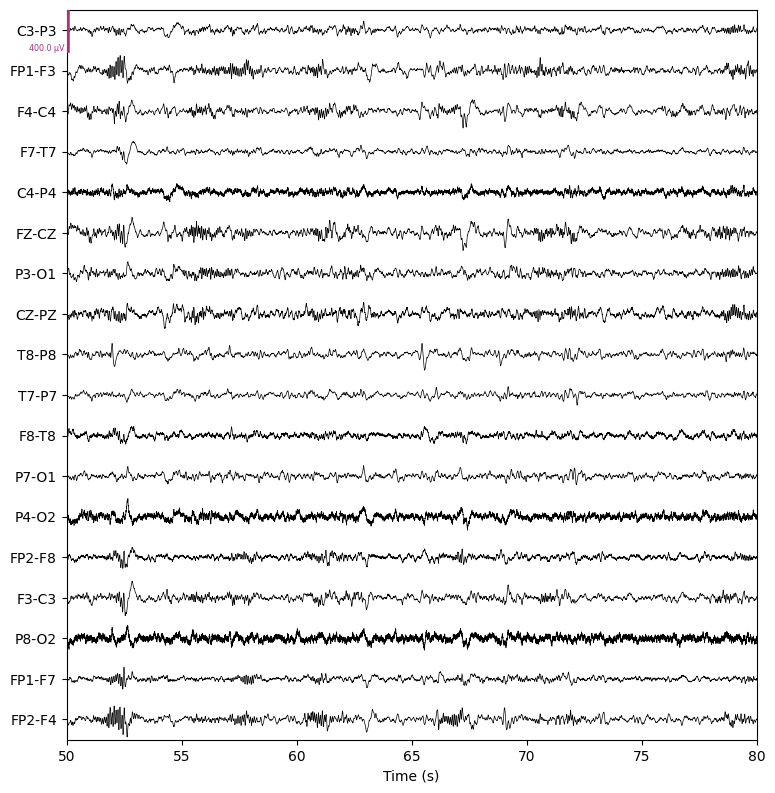

Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



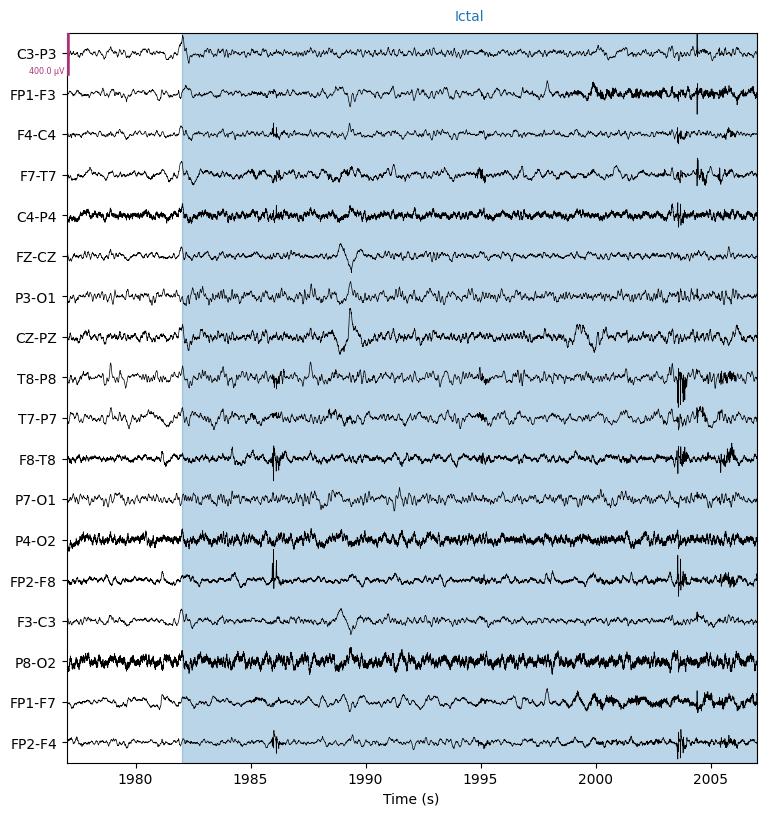

In [10]:
import mne

def crear_objeto_mne(datos, frecuencia, eventos=None):
  # Crear un archivo de información MNE con metadatos sobre el EEG
  info = mne.create_info(ch_names=list(datos.columns),
                         sfreq=frecuencia,
                         ch_types=['eeg']*datos.shape[-1])

  # Los datos deben estar en voltios en lugar de microvoltios
  datos = datos.apply(lambda x: x*1e-6)
  # Transponer los datos
  datos_T = datos.transpose()

  # Crear el objeto MNE Raw
  raw = mne.io.RawArray(datos_T, info)

  if eventos:
    start_times = np.array(eventos[::2])
    end_times = np.array(eventos[1::2])
    anno_length = end_times - start_times
    event_name = np.array(['Ictal']*len(anno_length))

    raw.set_annotations(mne.Annotations(start_times,
                                        anno_length,
                                        event_name))

  return raw

datos_mne = crear_objeto_mne(datos_crudos, frecuencia, info_participantes[ID_EJEMPLO]['Ventana_Convulsiones'])
info_participantes
datos_mne.plot(start=50, duration=30, **plot_kwargs);

tiempo_inicio_convulsion = info_participantes[ID_EJEMPLO]['Ventana_Convulsiones'][0]
datos_mne.plot(start=tiempo_inicio_convulsion-5, duration=30, **plot_kwargs);

## ML-Regresión

Se usará regresión para predecir un valor continuo relacionados con las señales EEG. A su vez, se evaluarán métricas como RMSE Y MAE.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Mostrar primeraas filas de la estructura de los datos
print(datos_crudos.head())

# Verificar que no hayan datos nulos
print(datos_crudos.isnull().sum())
print(datos_crudos.info())

Canal        C3-P3     FP1-F3      F4-C4      F7-T7       C4-P4      FZ-CZ  \
Tiempo                                                                       
0.000000  8.791209  51.770451  25.982906  63.492062 -116.630035 -44.346764   
0.003906  0.195360   0.195360   0.195360   0.195360    0.195360   0.195360   
0.007812  0.195360   0.195360   0.195360   0.195360   -0.195360   0.195360   
0.011719 -0.195360   0.195360   0.195360   0.586081   -3.711844  -0.586081   
0.015625  0.195360   0.195360   0.195360   0.195360    1.367521   0.586081   

Canal         P3-O1      CZ-PZ     T8-P8     T7-P7       F8-T8      P7-O1  \
Tiempo                                                                      
0.000000  35.750916  18.949940  0.976801 -6.837607  104.908424  16.214897   
0.003906   0.195360   0.195360  0.195360  0.195360    0.195360   0.195360   
0.007812   0.195360  -0.195360  0.195360  0.195360    0.195360   0.195360   
0.011719   0.195360  -1.758242 -0.195360  0.195360    2.148962   0.1

In [14]:
# Normalizar datos para que se encuentren en un rango similar
scaler = StandardScaler()
datos_crudos_norm = scaler.fit_transform(datos_crudos)

# Convertir a DataFrame
datos_crudos_norm = pd.DataFrame(datos_crudos_norm, columns=datos_crudos.columns)

# Mostrar los datos normalizados
print(datos_crudos_norm.head())

Canal     C3-P3    FP1-F3     F4-C4     F7-T7     C4-P4     FZ-CZ     P3-O1  \
0      0.340072  1.390545  0.778530  2.166836 -4.128304 -1.220235  1.174823   
1     -0.000032 -0.000123  0.000432  0.000623 -0.000104  0.000332 -0.000029   
2     -0.000032 -0.000123  0.000432  0.000623 -0.013911  0.000332 -0.000029   
3     -0.015492 -0.000123  0.000432  0.013995 -0.138171 -0.021082 -0.000029   
4     -0.000032 -0.000123  0.000432  0.000623  0.041316  0.011038 -0.000029   

Canal     CZ-PZ     T8-P8     T7-P7     F8-T8     P7-O1     P4-O2    FP2-F8  \
0      0.446864  0.023596 -0.253563  3.170818  0.529537 -2.208376 -0.902764   
1     -0.000020  0.000667  0.000422 -0.000196  0.000072 -0.000084  0.000003   
2     -0.009330  0.000667  0.000422 -0.000196  0.000072 -0.000084  0.000003   
3     -0.046570 -0.010797  0.000422  0.058965  0.000072 -0.091620 -0.060995   
4      0.037221  0.000667  0.000422 -0.000196  0.000072 -0.057294  0.000003   

Canal     F3-C3     P8-O2    FP1-F7    FP2-F4  
0 

In [15]:
print(datos_crudos.columns)

Index(['C3-P3', 'FP1-F3', 'F4-C4', 'F7-T7', 'C4-P4', 'FZ-CZ', 'P3-O1', 'CZ-PZ',
       'T8-P8', 'T7-P7', 'F8-T8', 'P7-O1', 'P4-O2', 'FP2-F8', 'F3-C3', 'P8-O2',
       'FP1-F7', 'FP2-F4'],
      dtype='object', name='Canal')


In [16]:
# Dividir datos en conjuntos de entrenamiento y prueba

X = datos_crudos_norm.drop(columns=['P8-O2'])  # Características
y = datos_crudos_norm['P8-O2']  # Etiqueta

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Usando modelo de regresión lineal

model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Mean Squared Error: 0.0006724909762851894
Mean Absolute Error: 0.020598849281668663


In [18]:
# Usando regresión con redes neuronales

from sklearn.neural_network import MLPRegressor

# Crear y entrenar el modelo
modelo_ann = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
modelo_ann.fit(X_train, y_train)

# Hacer predicciones
y_pred_ann = modelo_ann.predict(X_test)

# Evaluar el modelo
rmse_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))
mae_ann = mean_absolute_error(y_test, y_pred_ann)

print(f"RMSE (ANN): {rmse_ann}")
print(f"MAE (ANN): {mae_ann}")

RMSE (ANN): 0.021972300484776497
MAE (ANN): 0.01738862507045269


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo de red neuronal
modelo_nn = Sequential()
modelo_nn.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
modelo_nn.add(Dense(32, activation='relu'))
modelo_nn.add(Dense(1))  # Salida de una sola dimensión

# Compilar el modelo
modelo_nn.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
modelo_nn.fit(X_train_scaled, y_train, epochs=10, batch_size=10, verbose=1)

# Hacer predicciones
y_pred_nnn = modelo_nn.predict(X_test_scaled)

# Evaluar el modelo
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nnn))
mae_nn = mean_absolute_error(y_test, y_pred_nnn)

print(f"Red Neuronal - RMSE: {rmse_nn}")
print(f"Red Neuronal - MAE: {mae_nn}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
73728/73728 ━━━━━━━━━━━━━━━━━━━━ 147s 2ms/step - loss: 0.0241
Epoch 2/10
73728/73728 ━━━━━━━━━━━━━━━━━━━━ 120s 2ms/step - loss: 0.0013
Epoch 3/10
73728/73728 ━━━━━━━━━━━━━━━━━━━━ 124s 2ms/step - loss: 9.6537e-04
Epoch 4/10
73728/73728 ━━━━━━━━━━━━━━━━━━━━ 131s 2ms/step - loss: 8.1160e-04
Epoch 5/10
73728/73728 ━━━━━━━━━━━━━━━━━━━━ 152s 2ms/step - loss: 7.4635e-04
Epoch 6/10
73728/73728 ━━━━━━━━━━━━━━━━━━━━ 135s 2ms/step - loss: 7.0470e-04
Epoch 7/10
73728/73728 ━━━━━━━━━━━━━━━━━━━━ 131s 2ms/step - loss: 6.8522e-04
Epoch 8/10
73728/73728 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - loss: 6.6722e-04
Epoch 9/10
73728/73728 ━━━━━━━━━━━━━━━━━━━━ 137s 2ms/step - loss: 6.5977e-04
Epoch 10/10
73728/73728 ━━━━━━━━━━━━━━━━━━━━ 130s 2ms/step - loss: 6.5289e-04
5760/5760 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Red Neuronal - RMSE: 0.0229779239743948
Red Neuronal - MAE: 0.018132630735635757


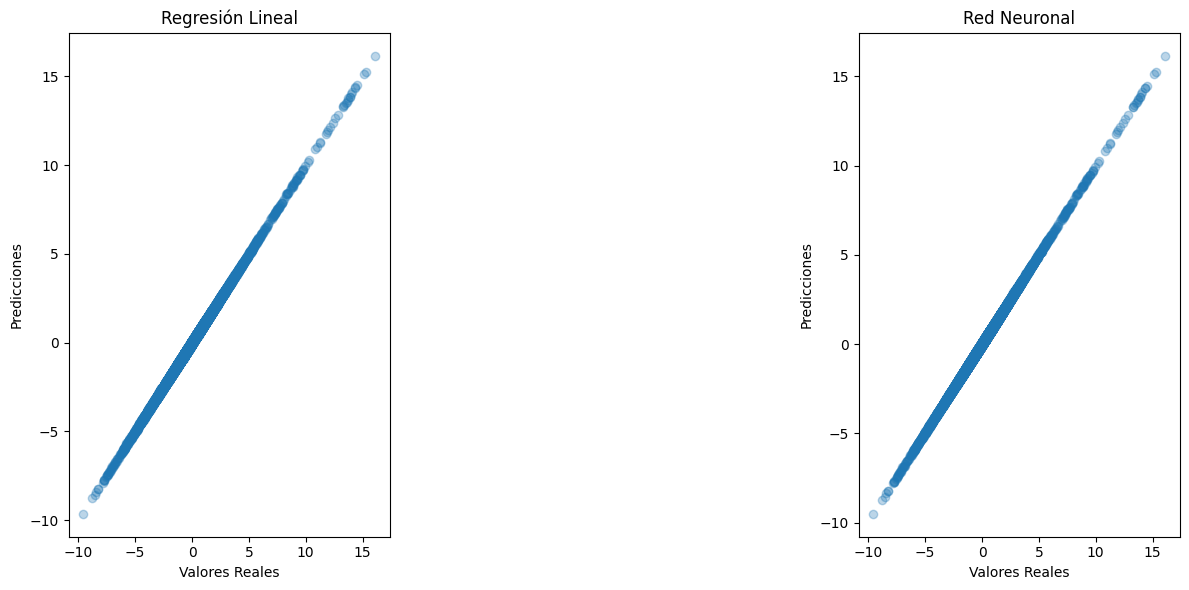

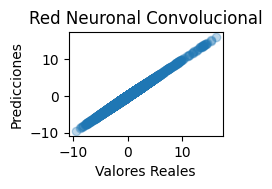

In [20]:
# Visualizar predicciones y valores reales
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Visualización para la regresión lineal
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.title('Regresión Lineal')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

# Visualización para la red neuronal
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_ann, alpha=0.3)
plt.title('Red Neuronal')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

plt.tight_layout()
plt.show()

# Visualización para la red neuronal
plt.subplot(3, 3, 3)
plt.scatter(y_test, y_pred_nnn, alpha=0.3)
plt.title('Red Neuronal Convolucional')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

plt.tight_layout()
plt.show()

Un **espectrograma** es una representación visual que nos permite entender cómo varía la energía de las señales, —en este caso, señales EEG (electroencefalograma)—, en diferentes frecuencias a lo largo del tiempo.

Los espectogramas son útiles para detectar patrones anómalos (convulsiones), pues algunas frecuencias son índices que pueden dominar durante distintos episodios convulsivos.

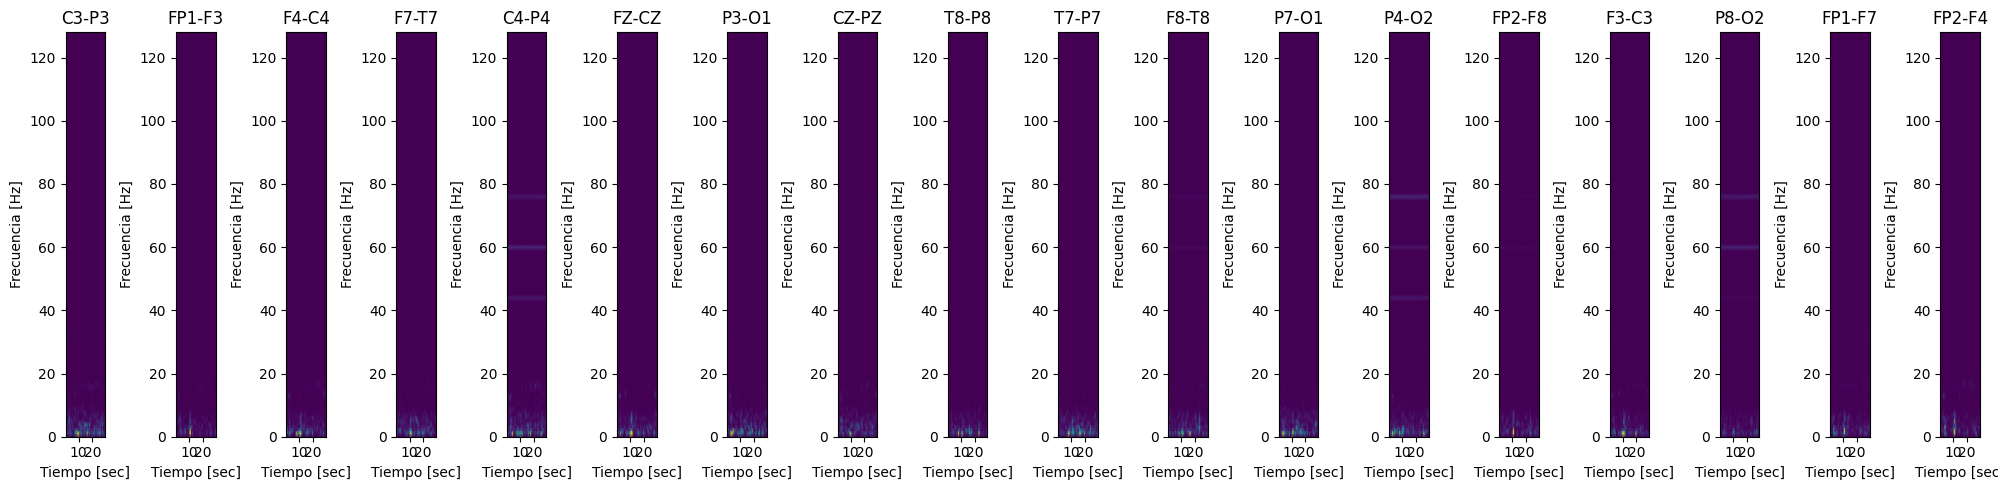

In [22]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Función para generar espectrogramas de segmentos de señales EEG
def generar_espectrogramas(datos, start, duration, freq):
    fig, axs = plt.subplots(1, len(datos.info['ch_names']), figsize=(20, 5))
    for i, canal in enumerate(datos.info['ch_names']):
        f, t, Sxx = signal.spectrogram(datos.get_data(picks=[i])[0, start*freq:(start+duration)*freq], fs=freq)
        axs[i].pcolormesh(t, f, Sxx, shading='gouraud')
        axs[i].set_title(canal)
        axs[i].set_xlabel('Tiempo [sec]')
        axs[i].set_ylabel('Frecuencia [Hz]')
    plt.tight_layout()
    plt.show()

# Generar espectrogramas para un periodo sin convulsión
generar_espectrogramas(datos_mne, start=0, duration=30, freq=int(frecuencia))

Al observar la gráfica, evidenciamos que en el eje X se encuentra el tiempo registrado, mientras que en el eje Y se representa qué componentes de la frecuencia están presente en la señal dada.

## Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


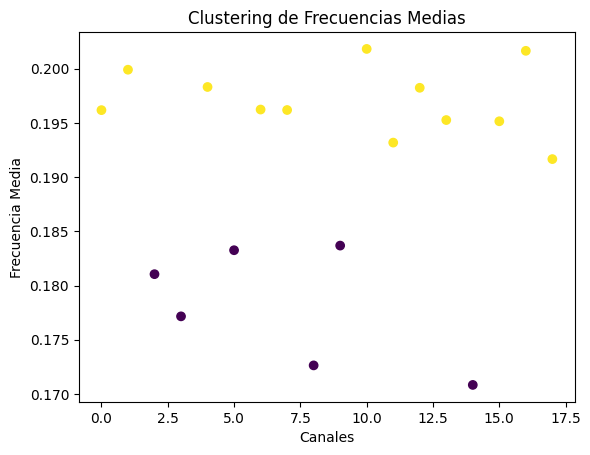

In [27]:
from sklearn.cluster import KMeans

# Usar la media de los datos de frecuencia como entrada para el clustering
frecuencias_medias = np.mean(datos_crudos.values, axis=0)
kmeans = KMeans(n_clusters=2, random_state=0).fit(frecuencias_medias.reshape(-1, 1))

# Visualizar los clusters
plt.scatter(np.arange(len(frecuencias_medias)), frecuencias_medias, c=kmeans.labels_)
plt.title("Clustering de Frecuencias Medias")
plt.xlabel("Canales")
plt.ylabel("Frecuencia Media")
plt.show()

# Conclusiones

1. **Carga de Datos:**
   Se implementó un proceso para descargar y leer los archivos de datos EEG desde PhysioNet. La utilización de `wfdb` y `pyedflib` permite acceder a las señales EEG. Se identificaron los canales más frecuentes entre los registros para garantizar que se incluyan las señales más significativas en el análisis.

2. **Procesamiento de Señales:**
   Se realizó un preprocesamiento de los datos, que incluyó la normalización de señales y la conversión a un formato adecuado para análisis posteriores. A su vez, la visualización de datos mediante gráficos de las señales EEG permitió identificar patrones y anomalías. Esto ayuda en la interpretación visual de la actividad cerebral durante diferentes estados (por ejemplo, ictal vs. interictal).

3. **Modelado y Evaluación:**
   Se aplicaron técnicas de regresión lineal y redes neuronales para predecir valores basados en las señales EEG. Los modelos se evaluaron utilizando métricas como el Error Cuadrático Medio (MSE) y el Error Absoluto Medio (MAE). La comparación entre modelos de regresión lineal y redes neuronales mostró que los modelos de redes neuronales pueden ofrecer una mejor precisión en la predicción, lo que sugiere que son más adecuados para el análisis de datos complejos como las señales EEG.

5. **Reflexiones Finales:**
   Los métodos y técnicas desarrollados en este proyecto pueden ser aplicados a otros estudios de señales EEG y problemas similares. La experiencia adquirida en el análisis y procesamiento de datos EEG es valiosa para futuros trabajos en el campo. Además, se intentará que este proyecto se desarrolle de mejor manera en el futuro.




# Referencias

1. Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng CK, Stanley HE. PhysioBank, PhysioToolkit y PhysioNet: componentes de un nuevo recurso de investigación para señales fisiológicas complejas. Circulation 101 (23):e215-e220 [Páginas electrónicas de Circulation; http://circ.ahajournals.org/cgi/content/full/101/23/e215 ]; 2000 (13 de junio).